<a href="https://colab.research.google.com/github/alina-bogdanovskaya/PyTorch_Jan2023/blob/lesson4/HW_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_dataset = torchvision.datasets.CIFAR100(root='data/',
                                              train=True,
                                              download=True)

test_dataset = torchvision.datasets.CIFAR100(root='data/',
                                             train=False, 
                                             download=True)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = train_dataset.classes

In [4]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])


In [5]:
train_ds = MyOwnCifar(train_dataset, trans_actions)
test_ds = MyOwnCifar(test_dataset, transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=32, 
                                           shuffle=True, 
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=train_ds, 
                                          batch_size=8, 
                                          shuffle=True,
                                          num_workers=2)

In [6]:
image, label = train_dataset[0]
image.size

(32, 32)

In [7]:
input = 3 * 32 * 32
output = len(train_dataset.classes)

In [8]:
def show_batch(dl):
    for batch in dl:
        images,labels = batch
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20], nrow=4).permute(1,2,0))
        break

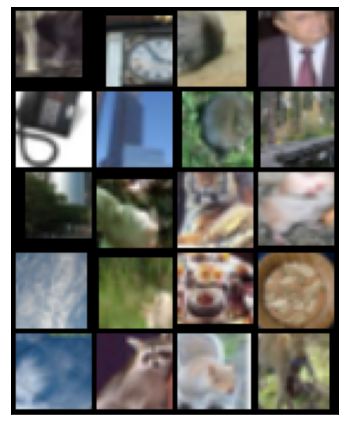

In [36]:
show_batch(train_loader)

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class ToDeviceLoader:
    def __init__(self, data, device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch, self.device)
            
    def __len__(self):
        return len(self.data)

In [10]:
device = get_device()
print(device)

train_data = ToDeviceLoader(train_loader, device)
test_data = ToDeviceLoader(test_loader, device)

cuda


In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [12]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
       
    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch}, train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

In [13]:
class MyCNN(BaseModel):
    def __init__(self):
        super().__init__()
        self.dp1 = nn.Dropout(0.2)
        self.dp2 = nn.Dropout(0.2)

        self.bn1 = torch.nn.BatchNorm2d(3) 
        self.conv1 = torch.nn.Conv2d(in_channels=3, 
                                     out_channels=20, 
                                     kernel_size=2, 
                                     stride=2)
        self.bn2 = torch.nn.BatchNorm2d(20) 
        self.conv2 = torch.nn.Conv2d(in_channels=20, 
                                     out_channels=40, 
                                     kernel_size=3, 
                                     stride=1,
                                     padding='same')
        self.bn3 = torch.nn.BatchNorm2d(40)
        self.conv3 = torch.nn.Conv2d(in_channels=40, 
                                     out_channels=80, 
                                     kernel_size=3, 
                                     stride=1,
                                     padding='same')
        self.bn4 = torch.nn.BatchNorm2d(80)
        self.conv4 = torch.nn.Conv2d(in_channels=80, 
                                     out_channels=160, 
                                     kernel_size=3, 
                                     stride=1, 
                                     padding='same')
        self.bn5 = torch.nn.BatchNorm2d(160)
        self.fc1 = torch.nn.Linear(640, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.out = torch.nn.Linear(128, 100)

    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.05)
        x = F.avg_pool2d(x, 2)
        
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn3(x)
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.1)
        x = F.adaptive_avg_pool2d(x, 2)
        
        x = self.bn4(x)
        x = self.conv4(x)
        x = F.leaky_relu(x, 0.075)
        #x = F.max_pool2d(x, 2)

        x = self.bn5(x)
        x = x.view(x.size(0), -1)
        x = self.dp1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        return self.out(x)

    def predict(self, x):
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.05)
        x = F.avg_pool2d(x, 2)
        
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn3(x)
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.1)
        x = F.adaptive_avg_pool2d(x, 2)
        
        x = self.bn4(x)
        x = self.conv4(x)
        x = F.leaky_relu(x, 0.075)
        #x = F.max_pool2d(x, 2)

        x = self.bn5(x)
        x = x.view(x.size(0), -1)
        x = self.dp1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.out(x)
        x = F.softmax(x)
        return x        

In [14]:
net = MyCNN()
# net = to_device(net, device)
net.cuda()

MyCNN(
  (dp1): Dropout(p=0.2, inplace=False)
  (dp2): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 20, kernel_size=(2, 2), stride=(2, 2))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn5): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=640, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=100, bias=True

In [15]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, scheduler):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), max_lr)
    
    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
              
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model,test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history

In [16]:
epochs = 50
optimizer = torch.optim.Adam
max_lr=0.01
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [19]:
history = [evaluate(net, test_data)]

In [20]:
%%time
history += fit(epochs=epochs, 
               train_dl=train_data,
               test_dl=test_data, 
               model=net, 
               optimizer=optimizer, 
               max_lr=max_lr, 
               scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch 0, train_loss: 3.9720, val_loss: 3.6416, val_acc: 0.1390
Epoch 1, train_loss: 3.6546, val_loss: 3.4876, val_acc: 0.1633
Epoch 2, train_loss: 3.5542, val_loss: 3.3816, val_acc: 0.1820
Epoch 3, train_loss: 3.5118, val_loss: 3.3485, val_acc: 0.1866
Epoch 4, train_loss: 3.4927, val_loss: 3.3861, val_acc: 0.1828
Epoch 5, train_loss: 3.4512, val_loss: 3.3736, val_acc: 0.1861
Epoch 6, train_loss: 3.4454, val_loss: 3.3878, val_acc: 0.1806
Epoch 7, train_loss: 3.4976, val_loss: 3.3983, val_acc: 0.1760
Epoch 8, train_loss: 3.5624, val_loss: 3.4653, val_acc: 0.1668
Epoch 9, train_loss: 3.6338, val_loss: 3.5294, val_acc: 0.1525
Epoch 10, train_loss: 3.6865, val_loss: 3.4861, val_acc: 0.1650
Epoch 11, train_loss: 3.7121, val_loss: 3.6206, val_acc: 0.1444
Epoch 12, train_loss: 3.7294, val_loss: 3.4897, val_acc: 0.1641
Epoch 13, train_loss: 3.7209, val_loss: 3.4227, val_acc: 0.1721
Epoch 14, train_loss: 3.7017, val_loss: 3.5987, val_acc: 0.1407
Epoch 15, train_loss: 3.6754, val_loss: 3.4552, va

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs');

def plot_losses(history):
    losses_train = [x['train_loss'] for x in history]
    losses_val = [x['val_loss'] for x in history]
    plt.plot(losses_train, '-o')
    plt.plot(losses_val, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Number of Epochs');

In [ ]:
print(history[0])

{'val_loss': 4.606322288513184, 'val_acc': 0.0094200000166893}


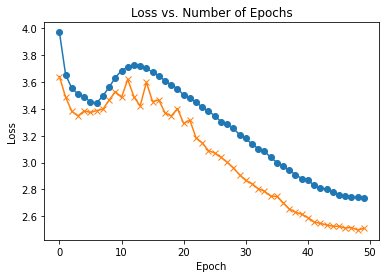

In [22]:
plot_losses(history[1:])

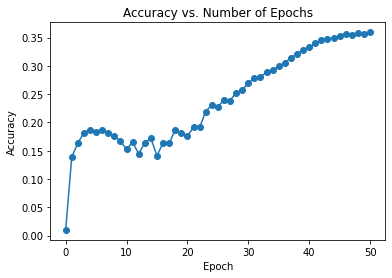

In [23]:
plot_accuracies(history)

In [24]:
data_iter = iter(test_data)
images, labels = next(data_iter)

Ground Truth:  wardrobe train orange maple_tree couch lizard butterfly rabbit
Predicted:  wardrobe streetcar poppy palm_tree bed trout beaver wolf


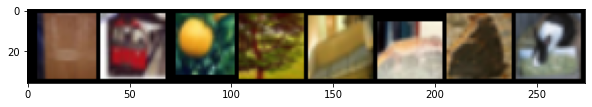

In [26]:
net.eval()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
imgs = make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).cpu().numpy())
print('Ground Truth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

In [27]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])
print(f'Accuracy: {(gt == pred).sum() / len(gt)}')

Accuracy: 0.125


In [32]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 20, 16, 16]             260
       BatchNorm2d-3             [-1, 20, 8, 8]              40
            Conv2d-4             [-1, 40, 8, 8]           7,240
       BatchNorm2d-5             [-1, 40, 4, 4]              80
            Conv2d-6             [-1, 80, 4, 4]          28,880
       BatchNorm2d-7             [-1, 80, 2, 2]             160
            Conv2d-8            [-1, 160, 2, 2]         115,360
       BatchNorm2d-9            [-1, 160, 2, 2]             320
          Dropout-10                  [-1, 640]               0
           Linear-11                  [-1, 256]         164,096
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
           Linear-14                  [

In [28]:
resnet = torchvision.models.resnet50(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [29]:
for param in list(resnet.parameters())[:]:
    param.requires_grad = False

In [30]:
from torchsummary import summary
summary(resnet.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [31]:
resnet.fc = nn.Linear(2048, 100)
summary(resnet.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [42]:
train_actions_rs = transforms.Compose([transforms.Resize(232),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(232),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_ds_rs = MyOwnCifar(train_dataset, train_actions_rs)
test_ds_rs = MyOwnCifar(test_dataset, test_transforms)

In [43]:
train_loader_rs = torch.utils.data.DataLoader(train_ds_rs,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader_rs = torch.utils.data.DataLoader(test_ds_rs,
                                           batch_size=16,
                                           shuffle=False,
                                           num_workers=1)

In [44]:
resnet = resnet.to(device)

In [45]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [46]:
epochs = 10
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [47]:
resnet.train()

for epoch in range(epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader_rs):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader_rs)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(test_loader_rs):
            
                test_outputs = resnet(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/391]. Loss: 0.023. Acc: 0.367. Test acc: 0.401
Epoch [1/10]. Step [301/391]. Loss: 0.017. Acc: 0.497. Test acc: 0.535
Epoch [2/10]. Step [1/391]. Loss: 0.011. Acc: 0.641. Test acc: 0.545
Epoch [2/10]. Step [301/391]. Loss: 0.012. Acc: 0.590. Test acc: 0.582
Epoch [3/10]. Step [1/391]. Loss: 0.011. Acc: 0.594. Test acc: 0.586
Epoch [3/10]. Step [301/391]. Loss: 0.011. Acc: 0.632. Test acc: 0.593
Epoch [4/10]. Step [1/391]. Loss: 0.009. Acc: 0.672. Test acc: 0.603
Epoch [4/10]. Step [301/391]. Loss: 0.010. Acc: 0.654. Test acc: 0.611
Epoch [5/10]. Step [1/391]. Loss: 0.010. Acc: 0.617. Test acc: 0.614
Epoch [5/10]. Step [301/391]. Loss: 0.009. Acc: 0.670. Test acc: 0.620
Epoch [6/10]. Step [1/391]. Loss: 0.010. Acc: 0.641. Test acc: 0.620
Epoch [6/10]. Step [301/391]. Loss: 0.009. Acc: 0.684. Test acc: 0.625
Epoch [7/10]. Step [1/391]. Loss: 0.007. Acc: 0.766. Test acc: 0.630
Epoch [7/10]. Step [301/391]. Loss: 0.009. Acc: 0.697. Test acc: 0.630
Epoch [8/10]. Step [